In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import scanpy as scp
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from mpl_toolkits.axes_grid.inset_locator import inset_axes
import matplotlib.patches as mpatches
import igraph
import scipy.stats as st
import bbknn
import os

from parameters import *

import sys
sys.path.append('../')
import single_cell_tools.tools as scttools
import single_cell_tools.plot as sctplot

2025-01-28 10:15:07.369476: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2025-01-28 10:15:07.369491: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
adata_embryo = scp.read("../Data_other_studies/Fadlullah/Fadlullah1.h5ad")
scp.pp.highly_variable_genes(adata_embryo)

In [3]:
adata_embryo.X = adata_embryo.layers["raw"].copy()
adata_embryo.var["gene_id"] = adata_embryo.var["gene_id"].values

# Global

In [4]:
adata_gastruloid = scp.read(DIRECTORY+"Results/QC.h5ad")
adata_gastruloid.var["gene_id"] = adata_gastruloid.var.index.values

## Centroid

In [5]:
m = adata_gastruloid.obs.groupby("leiden",dropna=False).count()

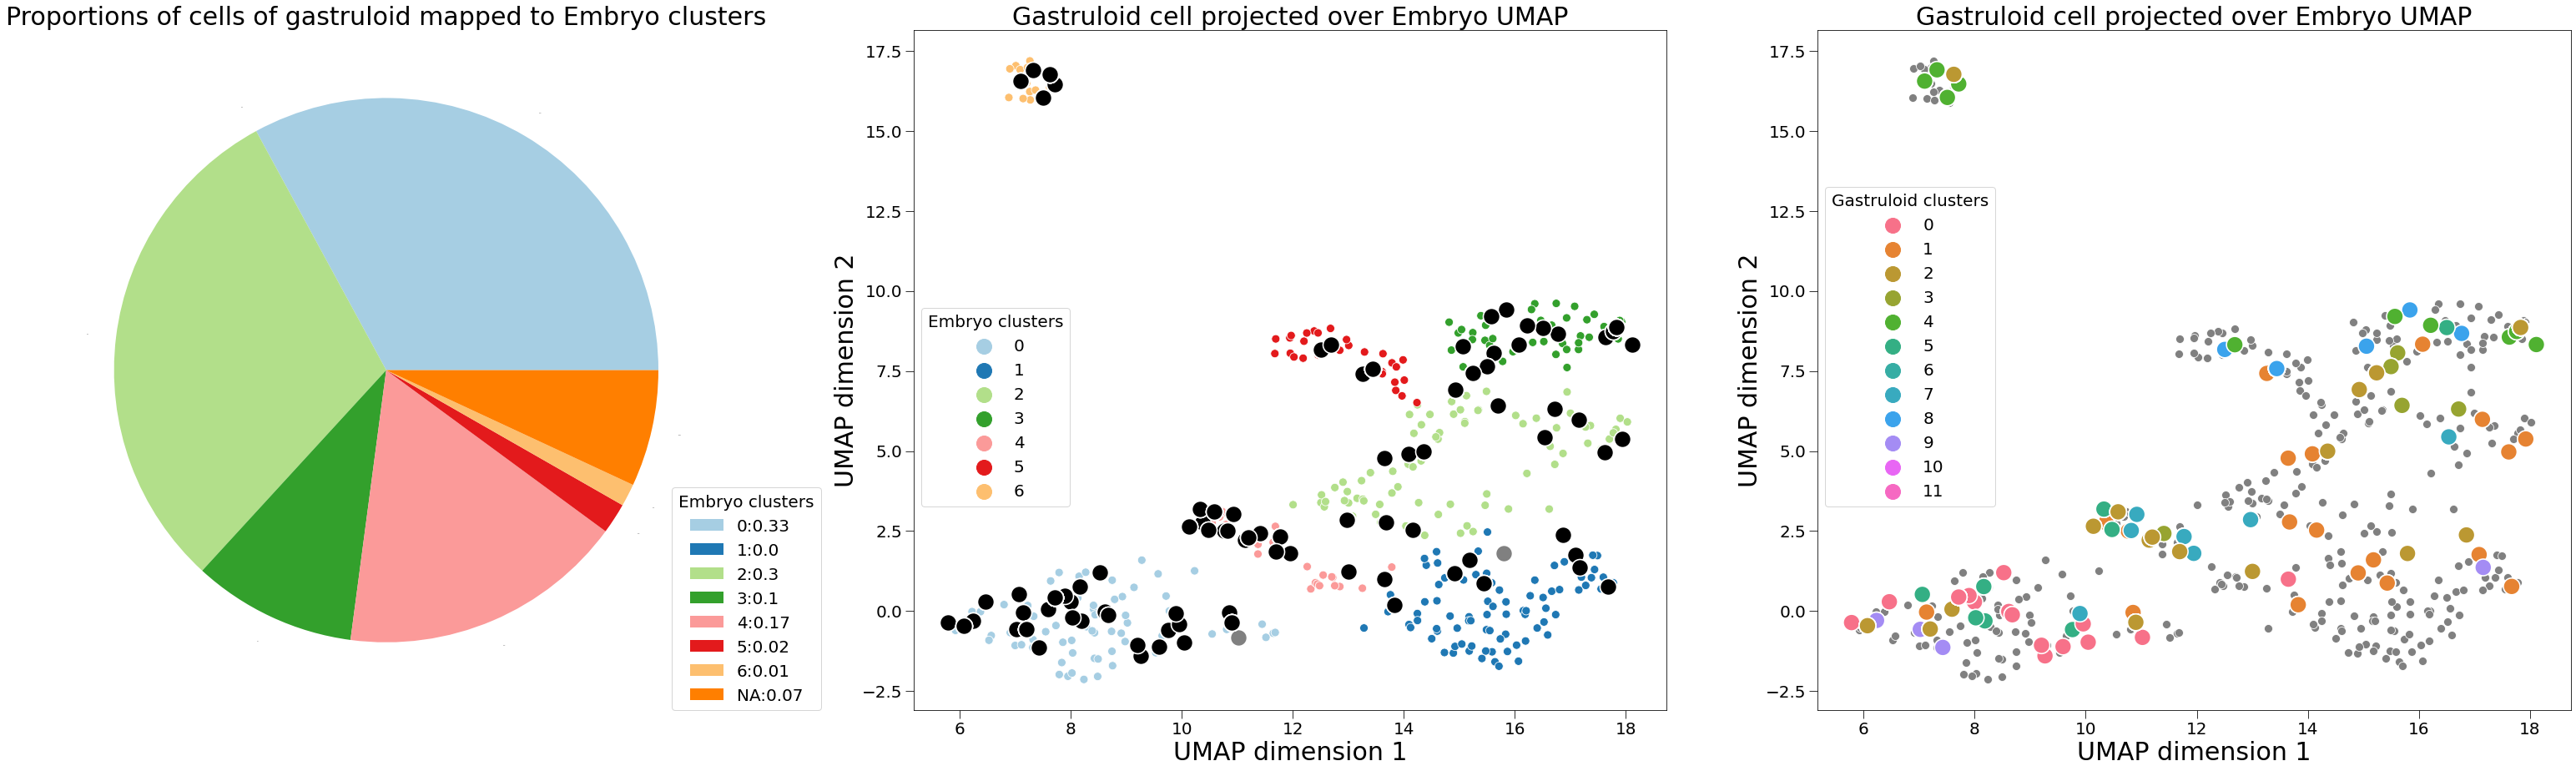

In [6]:
fig,ax = plt.subplots(1,3,figsize=[55,15])

scttools.scmap_annotate(adata_gastruloid,adata_embryo,"gene_id","leiden",key_added="Annotation",similarity_threshold=.7,algorithm_flavor="centroid",unassigned_label="100",verbose=False)
scttools.scmap_projection(adata_gastruloid,adata_embryo,"gene_id","X_umap",key_added="Annotation",verbose=False)

m = adata_gastruloid.obs.groupby("Annotation").count()
for i in adata_embryo.obs.groupby("leiden",dropna=False).count().index:
    if str(i) not in m.index.values:
        m.loc[str(i),:] = .001
m.index = m.index.astype(int)
m.sort_index(inplace=True)
labels = [str(i)+":"+str(np.round(j,decimals=2)) for i,j in zip(m.index,m.iloc[:,0]/m.iloc[:,0].sum())]
labels[-1] = "NA:"+labels[-1][4:]
m.plot.pie(y="Cell",ax=ax[0],fontsize=0,labels=labels,colors=sns.color_palette("Paired"))
sctplot.plot_base(ax[0],title="Proportions of cells of gastruloid mapped to Embryo clusters",labels=["",""],legend_pos=(.92,0),legend_title="Embryo clusters")

order = np.argsort(adata_embryo.obs["leiden"].astype(int)).values    
sns.scatterplot(adata_embryo.obsm["X_umap"][order,0],adata_embryo.obsm["X_umap"][order,1],hue=adata_embryo.obs["leiden"].astype(str).iloc[order],ax=ax[1],s=100,palette="Paired")
only = adata_gastruloid.obs["Annotation"] == "100"
sns.scatterplot(adata_gastruloid.obsm["Annotation"][only,0],adata_gastruloid.obsm["Annotation"][only,1],ax=ax[1],color="grey",s=400)
only = adata_gastruloid.obs["Annotation"] != "100"
sns.scatterplot(adata_gastruloid.obsm["Annotation"][only,0],adata_gastruloid.obsm["Annotation"][only,1],ax=ax[1],color="black",s=400)
sctplot.plot_base(ax[1],title="Gastruloid cell projected over Embryo UMAP",labels=["UMAP dimension 1","UMAP dimension 2"],legend_pos=(0.01,.3),legend_title="Embryo clusters",legend_markerscale=3)

sns.scatterplot(adata_embryo.obsm["X_umap"][:,0],adata_embryo.obsm["X_umap"][:,1],color="grey",ax=ax[2],s=100,palette="Paired")
sns.scatterplot(adata_gastruloid.obsm["Annotation"][:,0],adata_gastruloid.obsm["Annotation"][:,1],hue=adata_gastruloid.obs["leiden"].values,ax=ax[2],s=400)
sctplot.plot_base(ax[2],title="Gastruloid cell projected over Embryo UMAP",labels=["UMAP dimension 1","UMAP dimension 2"],legend_pos=(0.01,.3),legend_title="Gastruloid clusters",legend_markerscale=3)

fig.savefig(DIRECTORY+"Plots/Global/Proj_Fadlullah_datast_centroid_mapping.pdf",bbox_inches="tight",transparent=True)

In [7]:
if os.path.exists("./global_annotation_centroid.csv"):
    global_annotation = pd.read_csv("./global_annotation_centroid.csv")
else:
    global_annotation = pd.DataFrame()

global_annotation["Fadlullah1"] = adata_gastruloid.obs["Annotation"].values
global_annotation.to_csv("./global_annotation_centroid.csv",index=False)

## Cell

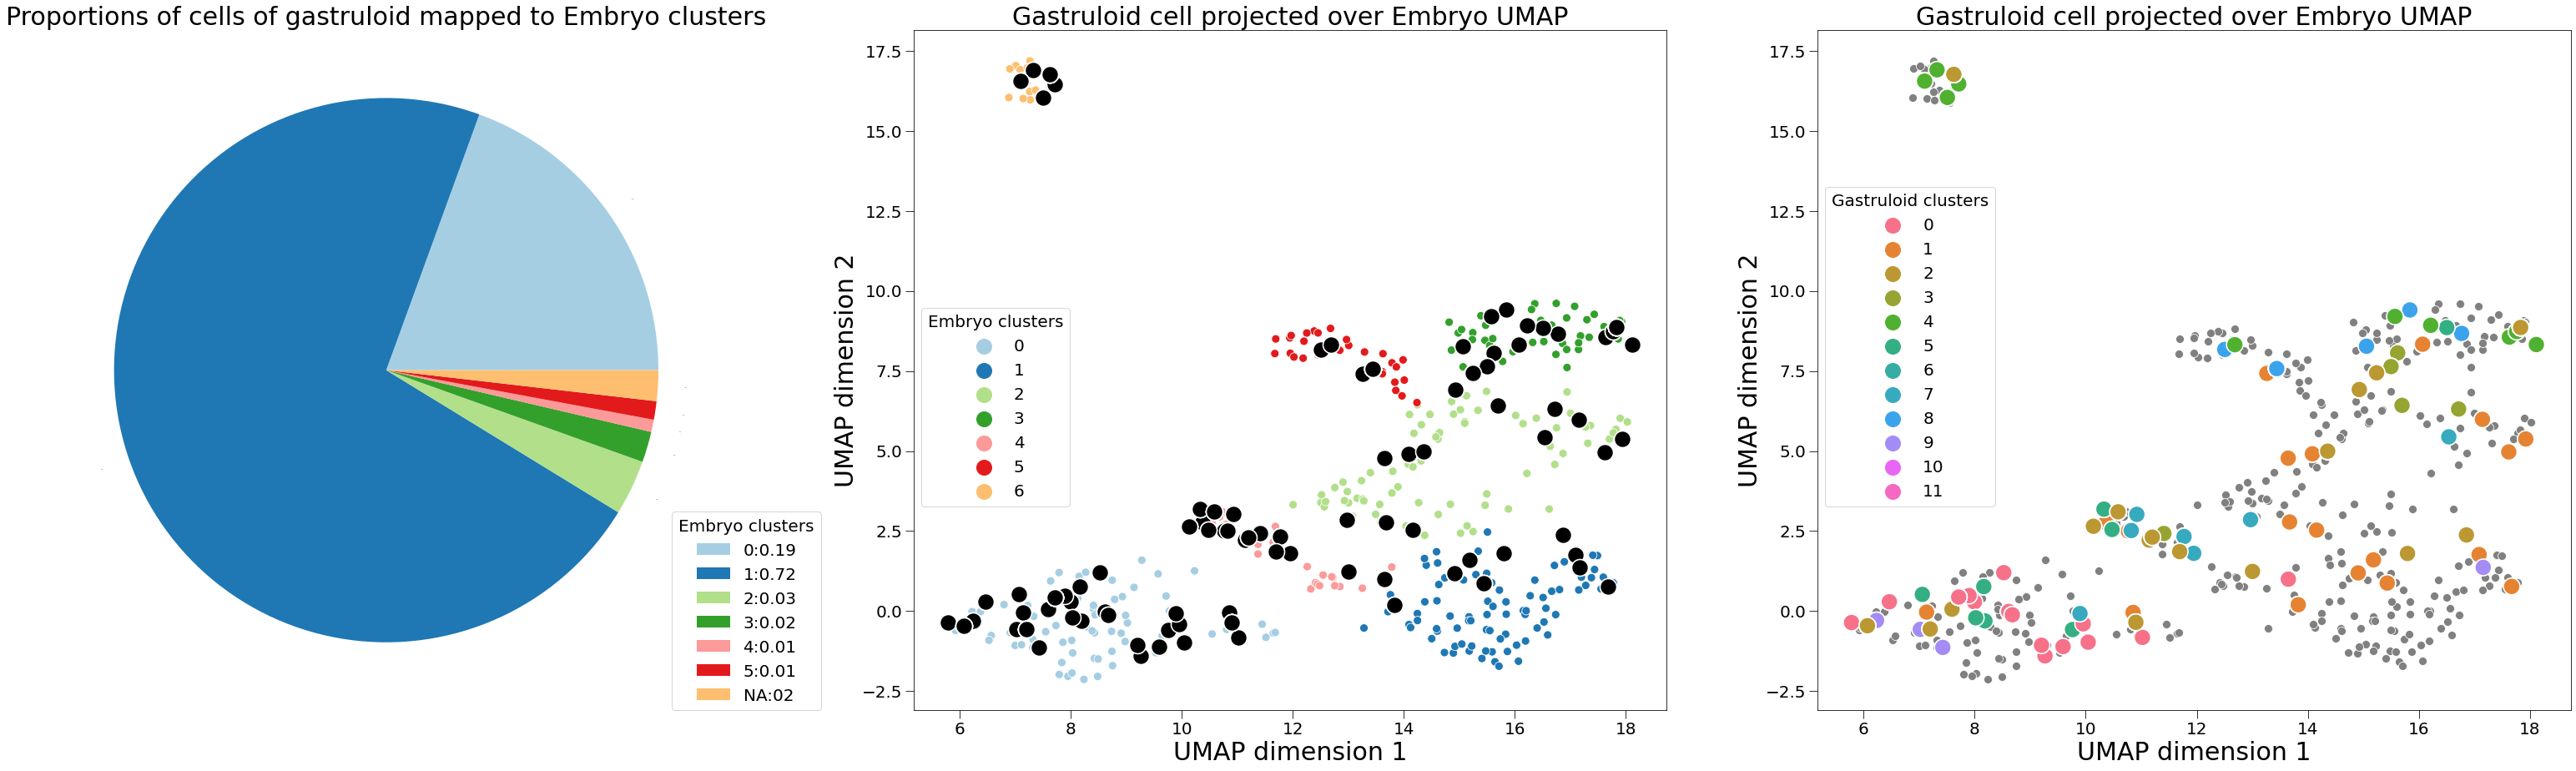

In [8]:
fig,ax = plt.subplots(1,3,figsize=[55,15])

scttools.scmap_annotate(adata_gastruloid,adata_embryo,"gene_id","leiden",key_added="Annotation",similarity_threshold=.7,algorithm_flavor="cell",unassigned_label="100",verbose=False)
scttools.scmap_projection(adata_gastruloid,adata_embryo,"gene_id","X_umap",key_added="Annotation",verbose=False)

m = adata_gastruloid.obs.groupby("Annotation").count()
for i in adata_embryo.obs.groupby("leiden",dropna=False).count().index:
    if str(i) not in m.index.values:
        m.loc[str(i),:] = .001
m.index = m.index.astype(int)
m.sort_index(inplace=True)
labels = [str(i)+":"+str(np.round(j,decimals=2)) for i,j in zip(m.index,m.iloc[:,0]/m.iloc[:,0].sum())]
labels[-1] = "NA:"+labels[-1][4:]
m.plot.pie(y="Cell",ax=ax[0],fontsize=0,labels=labels,colors=sns.color_palette("Paired"))
sctplot.plot_base(ax[0],title="Proportions of cells of gastruloid mapped to Embryo clusters",labels=["",""],legend_pos=(.92,0),legend_title="Embryo clusters")

order = np.argsort(adata_embryo.obs["leiden"].astype(int)).values    
sns.scatterplot(adata_embryo.obsm["X_umap"][order,0],adata_embryo.obsm["X_umap"][order,1],hue=adata_embryo.obs["leiden"].astype(str).iloc[order],ax=ax[1],s=100,palette="Paired")
only = adata_gastruloid.obs["Annotation"] == "100"
sns.scatterplot(adata_gastruloid.obsm["Annotation"][only,0],adata_gastruloid.obsm["Annotation"][only,1],ax=ax[1],color="grey",s=400)
only = adata_gastruloid.obs["Annotation"] != "100"
sns.scatterplot(adata_gastruloid.obsm["Annotation"][only,0],adata_gastruloid.obsm["Annotation"][only,1],ax=ax[1],color="black",s=400)
sctplot.plot_base(ax[1],title="Gastruloid cell projected over Embryo UMAP",labels=["UMAP dimension 1","UMAP dimension 2"],legend_pos=(0.01,.3),legend_title="Embryo clusters",legend_markerscale=3)

sns.scatterplot(adata_embryo.obsm["X_umap"][:,0],adata_embryo.obsm["X_umap"][:,1],color="grey",ax=ax[2],s=100,palette="Paired")
sns.scatterplot(adata_gastruloid.obsm["Annotation"][:,0],adata_gastruloid.obsm["Annotation"][:,1],hue=adata_gastruloid.obs["leiden"].values,ax=ax[2],s=400)
sctplot.plot_base(ax[2],title="Gastruloid cell projected over Embryo UMAP",labels=["UMAP dimension 1","UMAP dimension 2"],legend_pos=(0.01,.3),legend_title="Gastruloid clusters",legend_markerscale=3)

fig.savefig(DIRECTORY+"Plots/Global/Proj_Fadlullah_datast_cell_mapping.pdf",bbox_inches="tight",transparent=True)

In [9]:
if os.path.exists("./global_annotation_cell.csv"):
    global_annotation = pd.read_csv("./global_annotation_cell.csv")
else:
    global_annotation = pd.DataFrame()

global_annotation["Fadlullah1"] = adata_gastruloid.obs["Annotation"].values
global_annotation.to_csv("./global_annotation_cell.csv",index=False)

## DE genes from embryo expressed in gastruloid clusters

... storing 'leiden' as categorical
... storing 'Annotation' as categorical


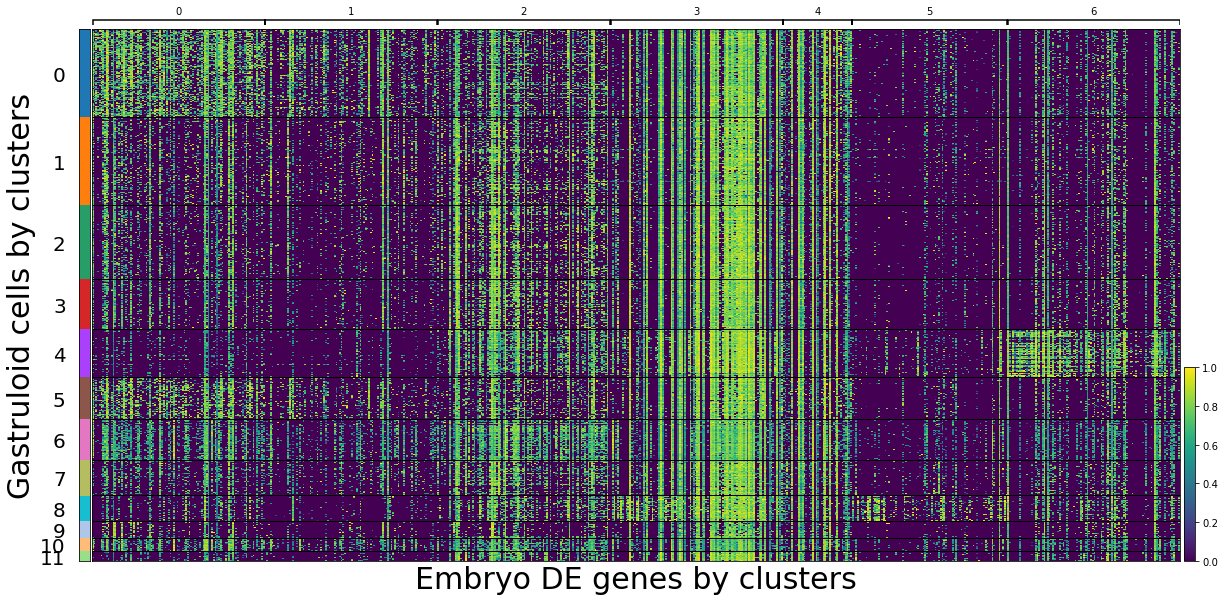

In [10]:
adata_embryo.obs["leiden"] = adata_embryo.obs["leiden"].astype(str)
adata_embryo.var.index = adata_embryo.var["gene_id"].values
scp.tl.rank_genes_groups(adata_embryo,groupby="leiden",method="wilcoxon")
    
cut = 5

cluster_genes = {}
for i,group in enumerate(adata_embryo.obs["leiden"].cat.categories.values):
    cluster_genes[group] = []
    for j in range(100):
        if adata_embryo.uns["rank_genes_groups"]["scores"][j][i] > cut and adata_embryo.uns["rank_genes_groups"]["names"][j][i] in adata_gastruloid.var["gene_id"].values:
            cluster_genes[group].append(adata_embryo.uns["rank_genes_groups"]["names"][j][i])
                
fig = scp.pl.heatmap(adata_gastruloid, cluster_genes, groupby="leiden", standard_scale="var", swap_axes=False, figsize=(20,10),show=False)
sctplot.plot_base(fig["heatmap_ax"],title="",labels=["Embryo DE genes by clusters",""],legend=False)
sctplot.plot_base(fig["groupby_ax"],title="",labels=["","Gastruloid cells by clusters"],legend=False)

plt.savefig(DIRECTORY+"Plots/Global/Proj_Fadlullah_DE_projected.pdf",bbox_inches="tight",transparent=True)

# Sorted

In [11]:
adata_gastruloid = scp.read(DIRECTORY+"Results/QC_sorted.h5ad")
adata_gastruloid.var["gene_id"] = adata_gastruloid.var.index.values

## Centroid

In [12]:
m = adata_gastruloid.obs.groupby("leiden",dropna=False).count()

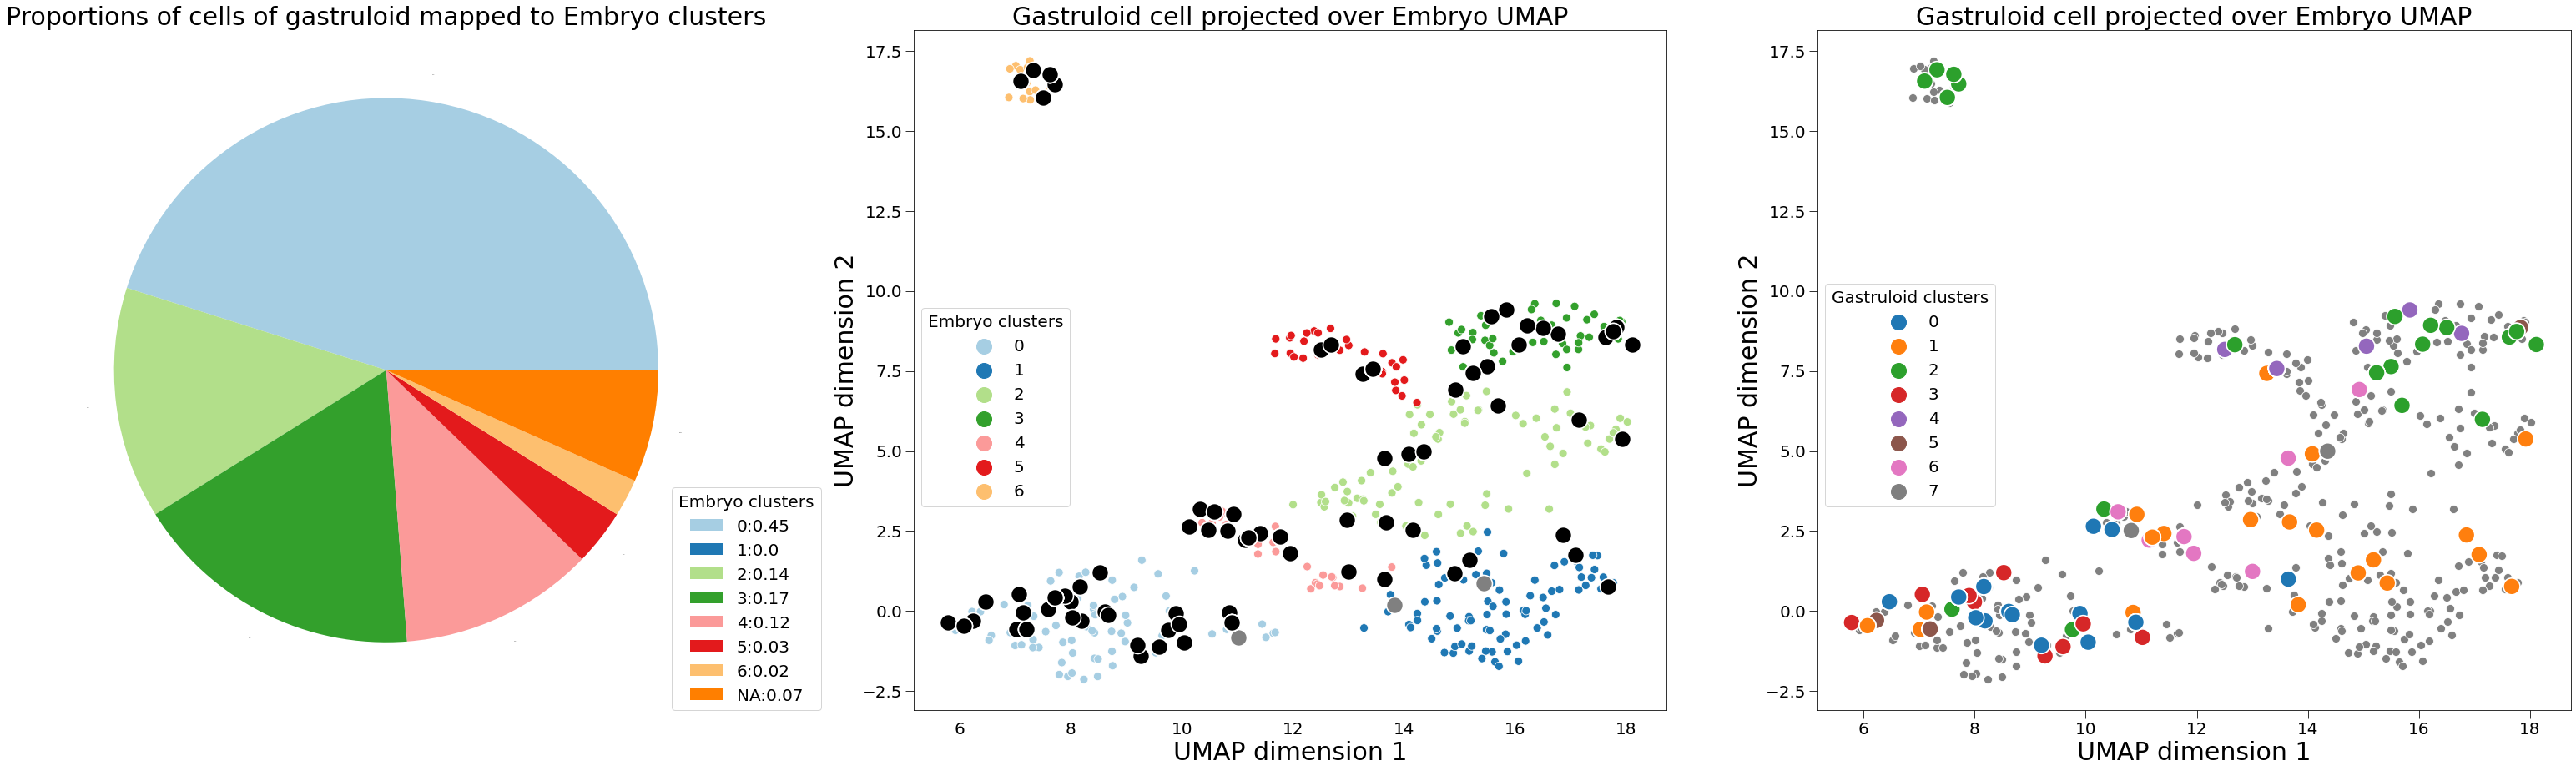

In [13]:
fig,ax = plt.subplots(1,3,figsize=[55,15])

scttools.scmap_annotate(adata_gastruloid,adata_embryo,"gene_id","leiden",key_added="Annotation",similarity_threshold=.7,algorithm_flavor="centroid",unassigned_label="100",verbose=False)
scttools.scmap_projection(adata_gastruloid,adata_embryo,"gene_id","X_umap",key_added="Annotation",verbose=False)

m = adata_gastruloid.obs.groupby("Annotation").count()
for i in adata_embryo.obs.groupby("leiden",dropna=False).count().index:
    if str(i) not in m.index.values:
        m.loc[str(i),:] = .001
m.index = m.index.astype(int)
m.sort_index(inplace=True)
labels = [str(i)+":"+str(np.round(j,decimals=2)) for i,j in zip(m.index,m.iloc[:,0]/m.iloc[:,0].sum())]
labels[-1] = "NA:"+labels[-1][4:]
m.plot.pie(y="Cell",ax=ax[0],fontsize=0,labels=labels,colors=sns.color_palette("Paired"))
sctplot.plot_base(ax[0],title="Proportions of cells of gastruloid mapped to Embryo clusters",labels=["",""],legend_pos=(.92,0),legend_title="Embryo clusters")

order = np.argsort(adata_embryo.obs["leiden"].astype(int)).values    
sns.scatterplot(adata_embryo.obsm["X_umap"][order,0],adata_embryo.obsm["X_umap"][order,1],hue=adata_embryo.obs["leiden"].astype(str).iloc[order],ax=ax[1],s=100,palette="Paired")
only = adata_gastruloid.obs["Annotation"] == "100"
sns.scatterplot(adata_gastruloid.obsm["Annotation"][only,0],adata_gastruloid.obsm["Annotation"][only,1],ax=ax[1],color="grey",s=400)
only = adata_gastruloid.obs["Annotation"] != "100"
sns.scatterplot(adata_gastruloid.obsm["Annotation"][only,0],adata_gastruloid.obsm["Annotation"][only,1],ax=ax[1],color="black",s=400)
sctplot.plot_base(ax[1],title="Gastruloid cell projected over Embryo UMAP",labels=["UMAP dimension 1","UMAP dimension 2"],legend_pos=(0.01,.3),legend_title="Embryo clusters",legend_markerscale=3)

sns.scatterplot(adata_embryo.obsm["X_umap"][:,0],adata_embryo.obsm["X_umap"][:,1],color="grey",ax=ax[2],s=100,palette="Paired")
sns.scatterplot(adata_gastruloid.obsm["Annotation"][:,0],adata_gastruloid.obsm["Annotation"][:,1],hue=adata_gastruloid.obs["leiden"].values,ax=ax[2],s=400)
sctplot.plot_base(ax[2],title="Gastruloid cell projected over Embryo UMAP",labels=["UMAP dimension 1","UMAP dimension 2"],legend_pos=(0.01,.3),legend_title="Gastruloid clusters",legend_markerscale=3)

fig.savefig(DIRECTORY+"Plots/Sorted/Proj_Fadlullah_datast_centroid_mapping.pdf",bbox_inches="tight",transparent=True)

In [14]:
if os.path.exists("./sorted_annotation_centroid.csv"):
    sorted_annotation = pd.read_csv("./sorted_annotation_centroid.csv")
else:
    sorted_annotation = pd.DataFrame()

sorted_annotation["Fadlullah1"] = adata_gastruloid.obs["Annotation"].values
sorted_annotation.to_csv("./sorted_annotation_centroid.csv",index=False)

## Cell

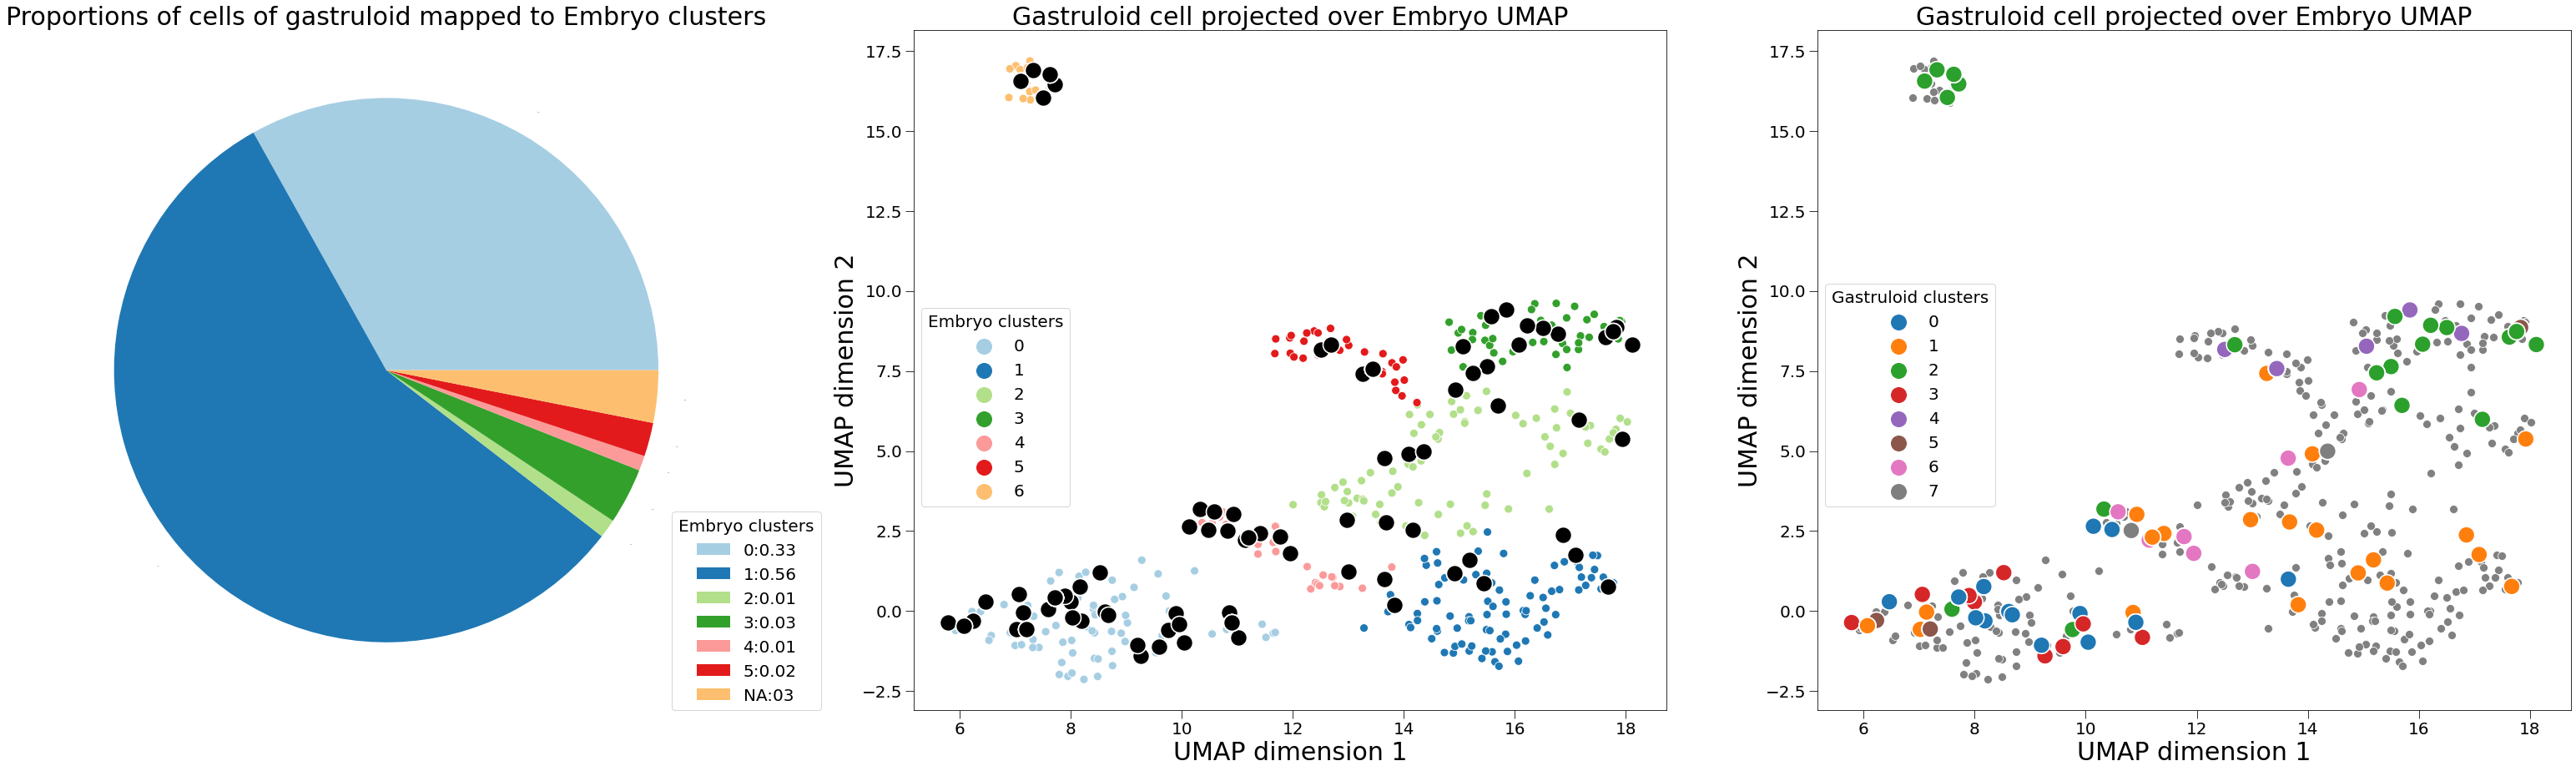

In [15]:
fig,ax = plt.subplots(1,3,figsize=[55,15])

scttools.scmap_annotate(adata_gastruloid,adata_embryo,"gene_id","leiden",key_added="Annotation",similarity_threshold=.7,algorithm_flavor="cell",unassigned_label="100",verbose=False)
scttools.scmap_projection(adata_gastruloid,adata_embryo,"gene_id","X_umap",key_added="Annotation",verbose=False)

m = adata_gastruloid.obs.groupby("Annotation").count()
for i in adata_embryo.obs.groupby("leiden",dropna=False).count().index:
    if str(i) not in m.index.values:
        m.loc[str(i),:] = .001
m.index = m.index.astype(int)
m.sort_index(inplace=True)
labels = [str(i)+":"+str(np.round(j,decimals=2)) for i,j in zip(m.index,m.iloc[:,0]/m.iloc[:,0].sum())]
labels[-1] = "NA:"+labels[-1][4:]
m.plot.pie(y="Cell",ax=ax[0],fontsize=0,labels=labels,colors=sns.color_palette("Paired"))
sctplot.plot_base(ax[0],title="Proportions of cells of gastruloid mapped to Embryo clusters",labels=["",""],legend_pos=(.92,0),legend_title="Embryo clusters")

order = np.argsort(adata_embryo.obs["leiden"].astype(int)).values    
sns.scatterplot(adata_embryo.obsm["X_umap"][order,0],adata_embryo.obsm["X_umap"][order,1],hue=adata_embryo.obs["leiden"].astype(str).iloc[order],ax=ax[1],s=100,palette="Paired")
only = adata_gastruloid.obs["Annotation"] == "100"
sns.scatterplot(adata_gastruloid.obsm["Annotation"][only,0],adata_gastruloid.obsm["Annotation"][only,1],ax=ax[1],color="grey",s=400)
only = adata_gastruloid.obs["Annotation"] != "100"
sns.scatterplot(adata_gastruloid.obsm["Annotation"][only,0],adata_gastruloid.obsm["Annotation"][only,1],ax=ax[1],color="black",s=400)
sctplot.plot_base(ax[1],title="Gastruloid cell projected over Embryo UMAP",labels=["UMAP dimension 1","UMAP dimension 2"],legend_pos=(0.01,.3),legend_title="Embryo clusters",legend_markerscale=3)

sns.scatterplot(adata_embryo.obsm["X_umap"][:,0],adata_embryo.obsm["X_umap"][:,1],color="grey",ax=ax[2],s=100,palette="Paired")
sns.scatterplot(adata_gastruloid.obsm["Annotation"][:,0],adata_gastruloid.obsm["Annotation"][:,1],hue=adata_gastruloid.obs["leiden"].values,ax=ax[2],s=400)
sctplot.plot_base(ax[2],title="Gastruloid cell projected over Embryo UMAP",labels=["UMAP dimension 1","UMAP dimension 2"],legend_pos=(0.01,.3),legend_title="Gastruloid clusters",legend_markerscale=3)

fig.savefig(DIRECTORY+"Plots/Sorted/Proj_Fadlullah_datast_cell_mapping.pdf",bbox_inches="tight",transparent=True)

In [16]:
if os.path.exists("./sorted_annotation_cell.csv"):
    sorted_annotation = pd.read_csv("./sorted_annotation_cell.csv")
else:
    sorted_annotation = pd.DataFrame()

sorted_annotation["Fadlullah1"] = adata_gastruloid.obs["Annotation"].values
sorted_annotation.to_csv("./sorted_annotation_cell.csv",index=False)

## DE genes from embryo expressed in gastruloid clusters

... storing 'leiden' as categorical
... storing 'Annotation' as categorical


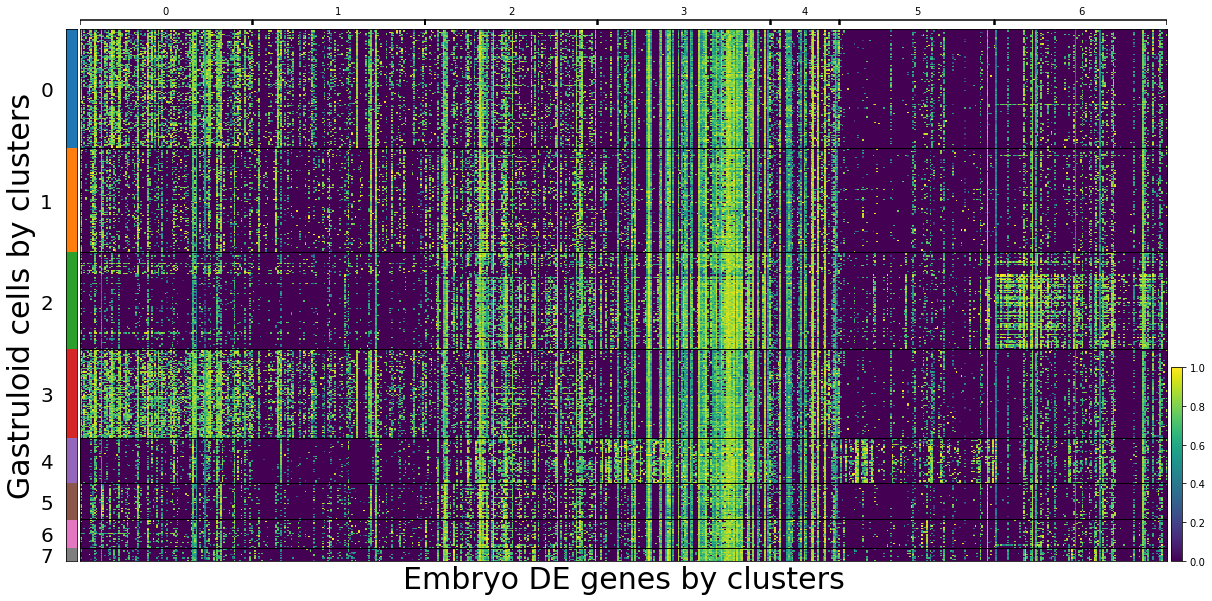

In [17]:
adata_embryo.obs["leiden"] = adata_embryo.obs["leiden"].astype(str)
adata_embryo.var.index = adata_embryo.var["gene_id"].values
scp.tl.rank_genes_groups(adata_embryo,groupby="leiden",method="wilcoxon")
    
cut = 5

cluster_genes = {}
for i,group in enumerate(adata_embryo.obs["leiden"].cat.categories.values):
    cluster_genes[group] = []
    for j in range(100):
        if adata_embryo.uns["rank_genes_groups"]["scores"][j][i] > cut and adata_embryo.uns["rank_genes_groups"]["names"][j][i] in adata_gastruloid.var["gene_id"].values:
            cluster_genes[group].append(adata_embryo.uns["rank_genes_groups"]["names"][j][i])
                
fig = scp.pl.heatmap(adata_gastruloid, cluster_genes, groupby="leiden", standard_scale="var", swap_axes=False, figsize=(20,10),show=False)
sctplot.plot_base(fig["heatmap_ax"],title="",labels=["Embryo DE genes by clusters",""],legend=False)
sctplot.plot_base(fig["groupby_ax"],title="",labels=["","Gastruloid cells by clusters"],legend=False)

plt.savefig(DIRECTORY+"Plots/Sorted/Proj_Fadlullah_DE_projected.pdf",bbox_inches="tight",transparent=True)